In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [20]:
epochs = 100

In [21]:
# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(256, z_dim)
        self.fc_logvar = nn.Linear(256, z_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_recon = self.decode(z)
        return x_recon, z_mean, z_logvar

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def decode(self, z):
        return self.decoder(z)

In [22]:
# 训练VAE
def train_vae(train_loader, valid_loader, vae, optimizer, criterion, epochs):
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = criterion(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader.dataset))
        
        valid_loss = validate(valid_loader, vae, criterion)
        valid_losses.append(valid_loss / len(valid_loader.dataset))
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.6f}, Valid Loss: {valid_losses[-1]:.6f}")
    return train_losses, valid_losses

In [23]:
# 验证VAE
def validate(valid_loader, vae, criterion):
    vae.eval()
    valid_loss = 0
    with torch.no_grad():
        for data, _ in valid_loader:
            recon_batch, mu, logvar = vae(data)
            valid_loss += criterion(recon_batch, data, mu, logvar).item()
    return valid_loss


In [24]:
# VAE loss
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [25]:
# 生成图片
def generate_images(vae, z_dim):
    vae.eval()
    if z_dim == 1:
        z = torch.linspace(-5, 5, 256).reshape(-1, 1)
    elif z_dim == 2:
        x = torch.linspace(-5, 5, 16)
        y = torch.linspace(-5, 5, 16)
        z = torch.cartesian_prod(x, y)
    else:
        raise ValueError("z_dim must be 1 or 2")
    x = vae.decode(z).detach().numpy()
    image = np.zeros((28 * 16, 28 * 16))
    for i in range(16):
        for j in range(16):
            image[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = x[i * 16 + j, 0].reshape(28, 28)
    plt.imshow(image, cmap='gray')

In [26]:
# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

Epoch 1/100, Train Loss: 192.759442, Valid Loss: 178.885186
Epoch 2/100, Train Loss: 176.509992, Valid Loss: 173.722423
Epoch 3/100, Train Loss: 172.691762, Valid Loss: 171.024947
Epoch 4/100, Train Loss: 170.608942, Valid Loss: 169.815384
Epoch 5/100, Train Loss: 169.245352, Valid Loss: 167.944869
Epoch 6/100, Train Loss: 168.055222, Valid Loss: 166.754397
Epoch 7/100, Train Loss: 167.266483, Valid Loss: 165.973339
Epoch 8/100, Train Loss: 166.364822, Valid Loss: 165.479656
Epoch 9/100, Train Loss: 165.725536, Valid Loss: 165.071147
Epoch 10/100, Train Loss: 165.132233, Valid Loss: 165.371557
Epoch 11/100, Train Loss: 164.715320, Valid Loss: 165.049549
Epoch 12/100, Train Loss: 164.195301, Valid Loss: 164.136189
Epoch 13/100, Train Loss: 163.691321, Valid Loss: 163.744280
Epoch 14/100, Train Loss: 163.174267, Valid Loss: 163.056132
Epoch 15/100, Train Loss: 162.855344, Valid Loss: 162.846319
Epoch 16/100, Train Loss: 162.317722, Valid Loss: 162.961671
Epoch 17/100, Train Loss: 161.960

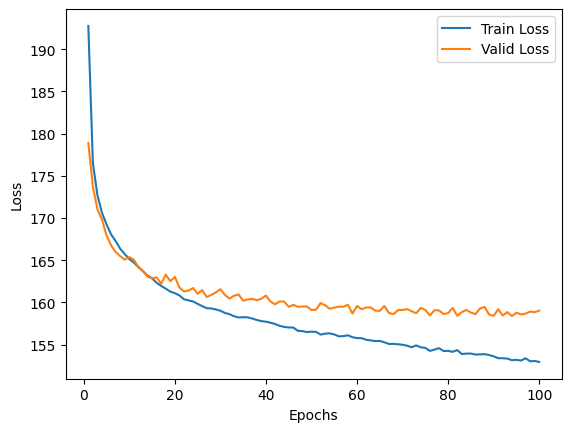

In [27]:
# 将隐层向量z维度设置为1
z_dim = 1
vae = VAE(z_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = vae_loss

train_losses, valid_losses = train_vae(train_loader, valid_loader, vae, optimizer, criterion, epochs)

plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generating images for z dimension = 1:


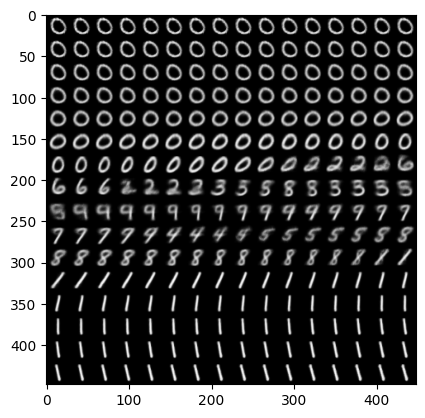

In [28]:
z_dim = 1
print("Generating images for z dimension = 1:")
generate_images(vae, z_dim)

Epoch 1/100, Train Loss: 187.344566, Valid Loss: 163.897110
Epoch 2/100, Train Loss: 159.574565, Valid Loss: 156.401994
Epoch 3/100, Train Loss: 154.274328, Valid Loss: 152.418984
Epoch 4/100, Train Loss: 151.305451, Valid Loss: 151.518671
Epoch 5/100, Train Loss: 149.343331, Valid Loss: 148.846024
Epoch 6/100, Train Loss: 147.826077, Valid Loss: 148.165141
Epoch 7/100, Train Loss: 146.743413, Valid Loss: 146.897460
Epoch 8/100, Train Loss: 145.785736, Valid Loss: 146.657392
Epoch 9/100, Train Loss: 144.957255, Valid Loss: 145.186887
Epoch 10/100, Train Loss: 144.169198, Valid Loss: 145.238159
Epoch 11/100, Train Loss: 143.574951, Valid Loss: 144.536854
Epoch 12/100, Train Loss: 142.992571, Valid Loss: 144.209117
Epoch 13/100, Train Loss: 142.520543, Valid Loss: 143.794385
Epoch 14/100, Train Loss: 142.016287, Valid Loss: 143.591606
Epoch 15/100, Train Loss: 141.576411, Valid Loss: 143.092629
Epoch 16/100, Train Loss: 141.203971, Valid Loss: 143.199431
Epoch 17/100, Train Loss: 140.806

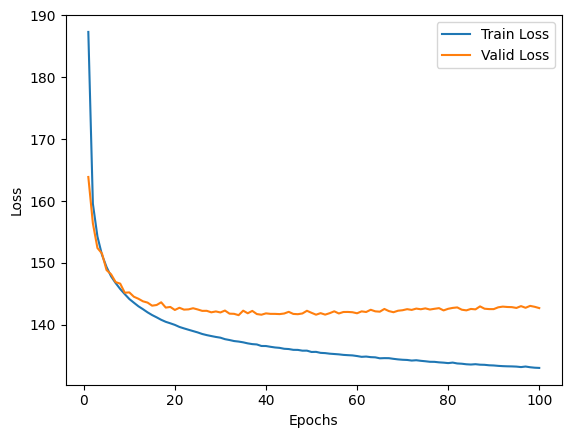

In [30]:
# 将隐层向量z维度设置为2
z_dim = 2
vae_2 = VAE(z_dim)
optimizer = optim.Adam(vae_2.parameters(), lr=1e-3)
criterion = vae_loss

train_losses, valid_losses = train_vae(train_loader, valid_loader, vae_2, optimizer, criterion, epochs)

plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generating images for z dimension = 2:


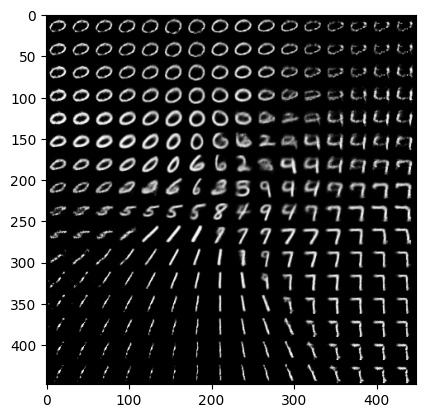

In [31]:
z_dim = 2
print("Generating images for z dimension = 2:")
generate_images(vae_2, z_dim)